# This notebook initializes a readout with ground truth from the Antolik's model and plots the result next to the Antolik's model's orientation map to check that it really works

In [22]:
from predict_neural_responses.models import *
import torch
from torch.nn import Parameter
from torch.nn import functional as F
import warnings

# from experiments.utils import pickle_read

import wandb
from Lurz_dataset import LurzDataModule

from models import reCNN_FullFactorized
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.progress import ProgressBar
import pytorch_lightning as pl

from pprint import pprint

from Antolik_dataset import AntolikDataModule
from experiments.utils import pickle_read, download_model, get_neuron_estimates, reconstruct_orientation_maps, visualize_preferred_orientations, rotate_and_compute_distances, circular_distance
from model_trainer import run_wandb_training
from models import reCNN_bottleneck_CyclicGauss3d_no_scaling
from model_trainer import Antolik_dataset_preparation_function

import sys
import pathlib
sys.path.insert(0, str(pathlib.Path("").resolve().parent)) #.. this has to be the folder reCNN_visual_prosthesis
import glob
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import pickle

### Setup the dataset

In [23]:
ENTITY = "csng-cuni"
PROJECT = "reCNN_visual_prosthesis"

model = None

config = {
    # GENERAL
    "seed": 42,
    "batch_size": 10,
    "lr": 0.001,
    "max_epochs": 500,
    # CORE GENERAL CONFIG
    "core_hidden_channels": 8,
    "core_layers": 5,
    "core_input_kern": 7,
    "core_hidden_kern": 9,
    # ROTATION EQUIVARIANCE CORE CONFIG
    "num_rotations": 8,
    "stride": 1,
    "upsampling": 2,
    "rot_eq_batch_norm": True,
    "stack": -1,
    "depth_separable": True,
    # READOUT CONFIG
    "readout_bias": False,
    "nonlinearity": "softplus",
    # REGULARIZATION
    "core_gamma_input": 0.00307424496692959,
    "core_gamma_hidden": 0.28463619129195233,
    "readout_gamma": 0.17,
    "input_regularizer": "LaplaceL2norm",  # for RotEqCore - default
    "use_avg_reg": True,
    "reg_readout_spatial_smoothness": 0.0027,
    "reg_group_sparsity": 0.1,
    "reg_spatial_sparsity": 0.45,
    # TRAINER
    "patience": 7,
    "train_on_val": False,  # in case you want to quickly check that your model "compiles" correctly
    "test": True,
    "observed_val_metric": "val/corr",
    "test_average_batch": False,
    "compute_oracle_fraction": False,
    "conservative_oracle": True,
    "jackknife_oracle": True,
    "generate_oracle_figure": False,
    # ANTOLIK
    "region": "region1",
    "dataset_artifact_name": "Antolik_dataset:latest",
    # BOTTLENECK
    "bottleneck_kernel": 15,
    "fixed_sigma": False,
    "init_mu_range": 0.9,
    "init_sigma_range": 0.8,
}

config.update(
    {
        "ground_truth_positions_file_path": "data/antolik/position_dictionary.pickle",
        "ground_truth_orientations_file_path": "data/antolik/oris.pickle",
        "init_to_ground_truth_positions": True,
        "init_to_ground_truth_orientations": True,
        "freeze_positions": False,
        "freeze_orientations": False,
        "orientation_shift": 87.42857142857143,
        "factor": 5.5,
        "filtered_neurons":None,
    }
)

In [24]:
dm = None
without_dataset = False

if without_dataset: 
    config.update(
            {
                "input_channels": 1,
                "input_size_x": 110,
                "input_size_y": 110,
                "num_neurons": 30000,
                "mean_activity": torch.zeros(30000),
            }
        )
else:
    path_train = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik/one_trials.pickle"
    path_test = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik/ten_trials.pickle"

    dataset_config = {
        "train_data_dir": path_test,
        "test_data_dir": path_test,
        "batch_size": config["batch_size"],
        "normalize": True,
        "val_size": 500,
        "brain_crop": 0.8,
        "stimulus_crop": "auto",
        "ground_truth_path": "data/antolik/position_dictionary.pickle",
    }


    dm = AntolikDataModule(**dataset_config)
    dm.prepare_data()
    dm.setup()

    # update config for initialization of model (<- certain config parameters depend on data)
    config.update(
        {
            "input_channels": dm.get_input_shape()[0],
            "input_size_x": dm.get_input_shape()[1],
            "input_size_y": dm.get_input_shape()[2],
            "num_neurons": dm.get_output_shape()[0],
            "mean_activity": dm.get_mean(),
            "filtered_neurons":dm.get_filtered_neurons(),
        }
    )

12px will be discarded from each side.
Data loaded successfully!
Loaded precomputed mean from /storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik/ten_trials_mean.npy


### Setup the reCNN network

In [25]:
model_class=reCNN_bottleneck_CyclicGauss3d_no_scaling
m = model_class(**config)
factor=5.5
x, y, ori = get_neuron_estimates(m, factor)
save=False

[   12    26    30 ... 29977 29982 29985]
old size of target_positions
torch.Size([30000, 3])
size of target_positions
torch.Size([4714, 3])


/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")
/opt/conda/lib/python3.8/site-packages/neuralpredictors/layers/cores/conv2d.py:128: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/auto/budejovice1/mpicek/reCNN_visual_prosthesis/readout.py:370: UserWarning: sigma is sampled from uniform distribuiton, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(


### Load ground truth and compare it to the 

The average distance error in x is 1.1959613854288014e-08
The average distance error in y is 1.1828755261010702e-08
The average distance error is 1.9507160097568973e-08


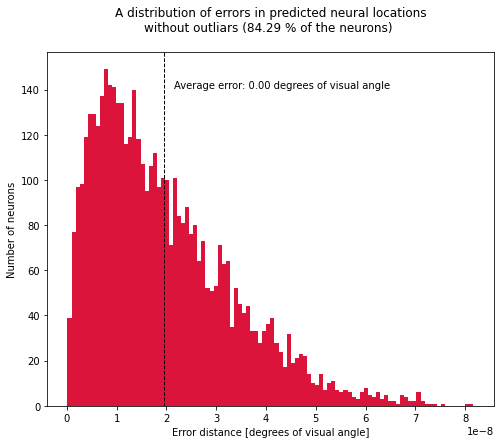

<Figure size 432x288 with 0 Axes>

In [26]:
# get the target values (values from the Antolik's computational model)
pos_dict = pickle_read("data/antolik/position_dictionary.pickle")
target_positions = np.concatenate([pos_dict['V1_Exc_L2/3'].T, pos_dict['V1_Inh_L2/3'].T])

if dm.get_filtered_neurons() is not None:
    target_positions = target_positions[dm.get_filtered_neurons(), :]

o_dict = pickle_read("data/antolik/oris.pickle")
target_ori = np.concatenate([np.array(o_dict['V1_Exc_L2/3']), np.array(o_dict['V1_Inh_L2/3'])])

num_of_neurons = len(target_positions)

# measure the errors in positions 
s_x = np.zeros((num_of_neurons))
s_y = np.zeros((num_of_neurons))
for i in range(num_of_neurons):
    s_x[i] = abs(x[i] - target_positions[i][0])
    s_y[i] = abs(y[i] + target_positions[i][1]) # it is upside down

avg_x = np.sum(s_x)/num_of_neurons
avg_y = np.sum(s_y)/num_of_neurons

distances = np.sqrt(s_x**2 + s_y**2)

print(f"The average distance error in x is {avg_x}")
print(f"The average distance error in y is {avg_y}")
print(f"The average distance error is {np.sum(distances)/num_of_neurons}")

avg_error = np.mean(distances)
distances = [x for x in distances if x < 0.1 * factor] # delete outliers

# and finally plot the distribution of distance errors
plt.gcf().set_size_inches(8, 6.5)
plt.hist(distances, bins=100, color="crimson")
plt.axvline(avg_error, color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(avg_error*1.1, max_ylim*0.9, 'Average error: {:.2f} degrees of visual angle'.format(avg_error))
plt.title("A distribution of errors in predicted neural locations\nwithout outliars ({:.2f} % of the neurons) \n".format((1 - len(distances)/30000) * 100))
plt.xlabel("Error distance [degrees of visual angle]")
plt.ylabel("Number of neurons")
if save:
    plt.savefig(img_path + "distribution_of_distances_errors", dpi = 300)
    print("saved")
plt.show()
plt.clf()

Average orientation error:
7.521136141060062e-06
Shift:
87.42857142857143


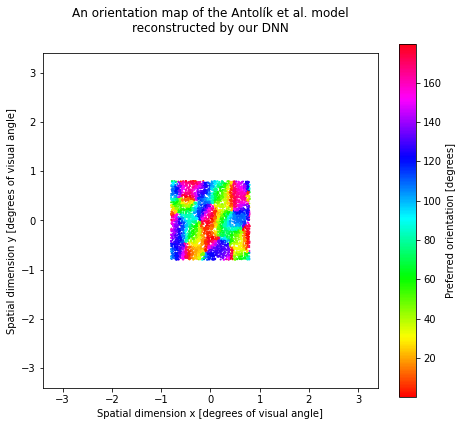

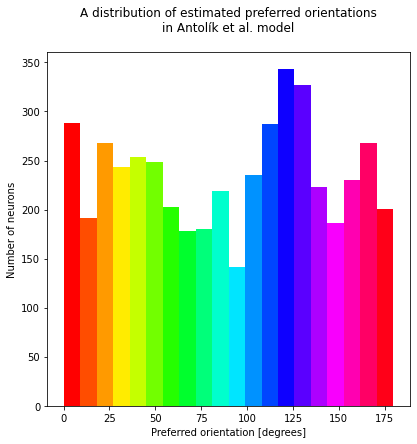

<Figure size 432x288 with 0 Axes>

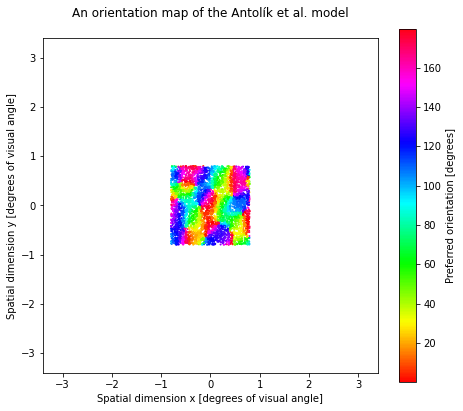

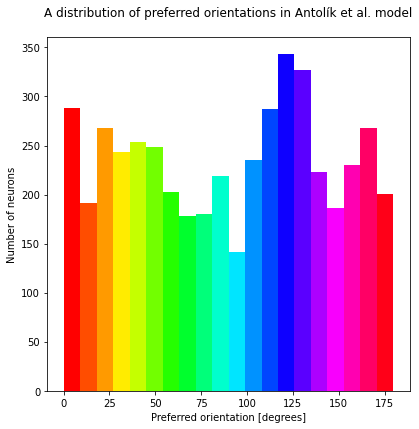

<Figure size 432x288 with 0 Axes>

In [27]:
o_dict = pickle_read("data/antolik/oris.pickle")
target_ori = np.concatenate([np.array(o_dict['V1_Exc_L2/3']), np.array(o_dict['V1_Inh_L2/3'])])

img_path = "imgomg/"
#####################################################################################
############################### Orientation errors ##################################
#####################################################################################

predicted_ori = np.array(ori)  # [0, 1]
predicted_ori = 180 * predicted_ori # [0, 180]

if dm.get_filtered_neurons() is not None:
    target_ori = target_ori[dm.get_filtered_neurons()]
target_ori = 180 * target_ori / np.pi # from [0, pi] to [0, 180]

result = rotate_and_compute_distances(predicted_ori, target_ori, period=180, n_rot=36)


f, ax = plt.subplots()

print("Average orientation error:")
print(result[0][np.argmin(result[0])])

print("Shift:")
print(result[1][np.argmin(result[0])])
shift = result[1][np.argmin(result[0])]
shift = 87.4

distances = circular_distance(((predicted_ori + shift) % 180), target_ori, 180) 

# we align the predicted orientations with the ground truth rotations (to have the same shift)
predicted_ori_aligned = (predicted_ori + shift) % 180 
reconstruct_orientation_maps(x, y, predicted_ori_aligned, f, ax, save, 12, 3.4, 3.4, img_path, "_antolik")
visualize_preferred_orientations(x, y, predicted_ori_aligned, f, ax, save, 12, 2.4, 2.4, img_path, "_antolik")

x = target_positions[:, 0]
y = target_positions[:, 1]
y = -y # as the y coordinate is upside down

f, ax = plt.subplots()
reconstruct_orientation_maps(x, y, target_ori, f, ax, save, 12, 3.4, 3.4, img_path, "_truth")
visualize_preferred_orientations(x, y, target_ori, f, ax, save, 12, 2.4, 2.4, img_path, "_truth")

